In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.signal import spectrogram
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [15]:
class TTTEEGBlock(nn.Module):
    def __init__(self, hidden_size, num_heads=4, head_dim=None, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else hidden_size // num_heads
        self.eta = eta
        
        self.W1 = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim) * 0.02)
        self.b1 = nn.Parameter(torch.zeros(num_heads, 1, self.head_dim))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, cache_params=None):
        B, L, C = x.shape
        
        x = self.layer_norm(x)
        x = x.reshape(B, L, self.num_heads, self.head_dim)
        x = x.permute(0, 2, 1, 3)  # [B, H, L, D]
        
        if cache_params is None:
            output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, self.W1) + self.b1.unsqueeze(0))
        else:
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                output_temp = torch.einsum('bhld,hdf->bhlf', x_temp, self.W1) + self.b1.unsqueeze(0)
                
                # Self-supervised loss: L2 loss + consistency loss
                l2_loss = output_temp.pow(2).mean()
                consistency_loss = torch.abs(output_temp - x_temp.mean(dim=-1, keepdim=True)).mean()
                self_supervised_loss = l2_loss + 0.1 * consistency_loss
                
                # Compute gradients for self-supervised loss
                grads = torch.autograd.grad(self_supervised_loss, [self.W1, self.b1], retain_graph=True, create_graph=False)
                grad_W1, grad_b1 = grads
                
                grad_W1 = torch.clamp(grad_W1, -1.0, 1.0)
                grad_b1 = torch.clamp(grad_b1, -1.0, 1.0)
                
                if f'W1_states_{id(self)}' not in cache_params:
                    cache_params[f'W1_states_{id(self)}'] = self.W1.clone()
                    cache_params[f'b1_states_{id(self)}'] = self.b1.clone()
                    cache_params[f'momentum_W1_{id(self)}'] = torch.zeros_like(self.W1)
                    cache_params[f'momentum_b1_{id(self)}'] = torch.zeros_like(self.b1)
                
                momentum = 0.9
                cache_params[f'momentum_W1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_W1_{id(self)}'] + 
                    (1 - momentum) * grad_W1
                )
                cache_params[f'momentum_b1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_b1_{id(self)}'] + 
                    (1 - momentum) * grad_b1
                )
                
                cache_params[f'W1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_W1_{id(self)}']
                cache_params[f'b1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_b1_{id(self)}']
                
                output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, 
                                    cache_params[f'W1_states_{id(self)}']) + 
                                    cache_params[f'b1_states_{id(self)}'].unsqueeze(0))
        
        output = output.permute(0, 2, 1, 3)  # [B, L, H, D]
        output = output.reshape(B, L, -1)     # [B, L, H*D]
        
        return output + x.permute(0, 2, 1, 3).reshape(B, L, -1)  # Residual connection

In [16]:
# Load EEG data from .mat files
def load_mat_data(file_path):
    data = loadmat(file_path)['data'][0]
    inputs, targets = [], []
    map = {}
    current = 3
    for i in range(len(data)):
        y = data[i].flatten()
        sub = y[0][0]
        if y[1][0]=='letter-composing':
            continue
        if y[2][0] not in ['trial 1','trial 2','trial 3']:
            continue
        eeg_data = y[3][:6, :]
        if sub not in map:
            map[sub] = current
            current += 1
        targets.append(map[sub])
        inputs.append(eeg_data)
    return np.array(inputs), np.array(targets)

def preprocess_eeg(eeg_data):
    eeg_data = (eeg_data - np.mean(eeg_data)) / (np.std(eeg_data) + 1e-8)
    nyq = 0.5 * 256
    low, high = 0.5 / nyq, 45 / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, eeg_data)

# Load EEG data from folder structure
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        for i in range(6):
                            X.append(eeg_data[3750:6250, i])
                            y.append(subject_idx)
    return np.array(X), np.array(y)

# Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], 1))
    return x * factor


def create_spectrogram(eeg_data, fs=256, target_area=2500, num_frequencies=50, num_times=50):   
    # Calculate the segment length (nperseg) based on the desired number of frequency bins
    # The formula for frequency bins is: number of bins = nperseg / 2 + 1
    required_nperseg = (num_frequencies - 1) * 2  # Desired frequency bins and corresponding nperseg

    # Ensure nperseg doesn't exceed the total signal length
    nperseg = min(required_nperseg, len(eeg_data))

    noverlap = nperseg // 2  # Overlap (half of segment length by default)

    # Compute the spectrogram
    frequencies, times, Sxx = spectrogram(
        eeg_data, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, detrend='constant', scaling='density'
    )

    # Ensure we get the expected number of frequency bins
    if Sxx.shape[0] < num_frequencies:
        print(f"Warning: Expected {num_frequencies} frequency bins, but got {Sxx.shape[0]}. Padding with zeros.")
        padding = num_frequencies - Sxx.shape[0]
        Sxx = np.pad(Sxx, ((0, padding), (0, 0)), mode='constant')
    elif Sxx.shape[0] > num_frequencies:
        # If the number of frequency bins is more than desired, truncate
        Sxx = Sxx[:num_frequencies, :]

    # Ensure the number of time bins matches the desired number
    if Sxx.shape[1] < num_times:
        padding = num_times - Sxx.shape[1]
        Sxx = np.pad(Sxx, ((0, 0), (0, padding)), mode='constant')
    elif Sxx.shape[1] > num_times:
        # Trim time bins if there are more than desired
        Sxx = Sxx[:, :num_times]

    # Convert to decibels
    Sxx = 10 * np.log10(Sxx + 1e-5)

    # Normalize the spectrogram
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)
    return Sxx

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class TTTCell(nn.Module):
    def __init__(self, input_size, hidden_size, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.eta = eta
        
        # Hidden state model (f in the paper)
        self.hidden_model = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # Initialize cache for test-time updates
        self.cache_params = {}
        
    def forward(self, x, hidden, is_training=True):
        if is_training:
            next_hidden = self.hidden_model(x)
        else:
            # Test-time training update
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                pred = self.hidden_model(x_temp)
                
                # Self-supervised loss (as described in paper section 2.1)
                l2_loss = pred.pow(2).mean()
                consistency_loss = torch.abs(pred - x_temp.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Update hidden model parameters
                grads = torch.autograd.grad(loss, self.hidden_model.parameters())
                
                with torch.no_grad():
                    for param, grad in zip(self.hidden_model.parameters(), grads):
                        if f'momentum_{id(param)}' not in self.cache_params:
                            self.cache_params[f'momentum_{id(param)}'] = torch.zeros_like(param)
                        
                        # Momentum update
                        self.cache_params[f'momentum_{id(param)}'].mul_(0.9).add_(grad, alpha=0.1)
                        param.add_(self.cache_params[f'momentum_{id(param)}'], alpha=-self.eta)
                
                next_hidden = self.hidden_model(x)
                
        return next_hidden


class TTTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create TTT cells for each layer
        self.cells = nn.ModuleList([
            TTTCell(
                input_size if i == 0 else hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])
    
    def forward(self, x, hidden=None, is_training=True):
        batch_size, seq_len, _ = x.shape
        
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size).to(x.device)
                     for _ in range(self.num_layers)]
        
        outputs = []
        for t in range(seq_len):
            layer_input = x[:, t, :]
            for layer_idx, cell in enumerate(self.cells):
                hidden[layer_idx] = cell(layer_input, hidden[layer_idx], is_training)
                layer_input = hidden[layer_idx]
            outputs.append(layer_input)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden


class EEGClassifier(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.cache_params = {}
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            # Initial block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 25x25
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6
            
            # Fourth block with global pooling
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to 1x1
        )
        
        # TTT blocks
        self.ttt_blocks = nn.ModuleList([
            TTTEEGBlock(hidden_size=256, num_heads=4)
            for _ in range(2)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),  # Now using 256 features from global pooling
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        
        # Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),  # From 256 features
            nn.ReLU(),
            nn.Linear(1024, 50 * 50)
        )
    
    def forward(self, x):
        # Print input shape for debugging
        # print("Input shape:", x.shape)
        
        # Ensure input shape [B, C, H, W]
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Extract features
        features = self.feature_extractor(x)  # [B, 256, 1, 1]
        # print("After feature extractor:", features.shape)
        
        # Reshape for TTT blocks
        features = features.squeeze(-1).squeeze(-1)  # [B, 256]
        features = features.unsqueeze(1)  # [B, 1, 256]
        
        # Apply TTT blocks
        for block in self.ttt_blocks:
            features = block(features, self.cache_params)
        
        # Prepare for classification
        features = features.squeeze(1)  # [B, 256]
        
        # Classification
        logits = self.classifier(features)
        
        # Reconstruction
        recon = self.decoder(features)
        recon = recon.view(-1, 1, 50, 50)
        
        return logits, recon
    
def SEBlock(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(channels, channels, kernel_size=1),
        nn.Sigmoid()
    )


def ResidualBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.GELU(),
        SEBlock(out_channels),
    )

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_val_acc = 0
    patience = 7
    patience_counter = 0

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.float()
            optimizer.zero_grad(set_to_none=True)
            
            try:
                # Forward pass
                outputs, recon = model(inputs)
                
                # Calculate losses
                ce_loss = criterion(outputs, labels)
                recon_loss = F.mse_loss(recon, inputs)
                loss = ce_loss + 0.1 * recon_loss
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                # Update metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{running_loss/(batch_idx+1):.4f}',
                })
                
            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {e}")
                print(f"Input shape: {inputs.shape}")
                raise e
            
        # Compute metrics for the training phase
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        train_accuracy = accuracy_score(all_labels, all_preds)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        print(f"\nEpoch {epoch+1} Training - Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        
        # Validation phase
        model.eval()
        val_preds = []
        val_labels = []
        val_running_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float()
                outputs, recon = model(inputs)
                ce_loss = criterion(outputs, labels)
                recon_loss = F.mse_loss(recon, inputs)
                loss = ce_loss + 0.1 * recon_loss
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Compute metrics for the validation phase
        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        print(f"\nEpoch {epoch+1} Validation - Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        
        # Early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_accuracy,
            }, 'best_model_latest.pth')
        else:
            patience_counter += 1
            # if patience_counter >= patience:
            #     print(f'Early stopping triggered. Best validation accuracy: {best_val_acc:.4f}')
            #     checkpoint = torch.load('best_model.pth')
            #     model.load_state_dict(checkpoint['model_state_dict'])
            #     break
    
    # Plot the metrics
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precisions, label='Train Precision')
    plt.plot(epochs, val_precisions, label='Val Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_recalls, label='Train Recall')
    plt.plot(epochs, val_recalls, label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model

In [19]:
class EEGDataset(Dataset):
    def __init__(self, data, labels, augment=False):
        self.data = []
        self.labels = []
        
        for i, eeg in enumerate(tqdm(data, desc="Creating spectrograms")):
            for channel in range(eeg.shape[0]):
                spectrogram = create_spectrogram(preprocess_eeg(eeg[channel]))
                if augment:
                    # Add more augmentations
                    specs = [
                        spectrogram,
                        jitter(spectrogram, sigma=0.01),
                        scaling(spectrogram, sigma=0.1),
                        add_noise(spectrogram, noise_level=0.01),
                        time_warp(spectrogram, sigma=2)
                    ]
                    for spec in specs:
                        self.data.append(spec)
                        self.labels.append(labels[i])
                else:
                    self.data.append(spectrogram)
                    self.labels.append(labels[i])
        
        self.data = torch.FloatTensor(np.stack(self.data))
        self.data = self.data.unsqueeze(1)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def add_noise(x, noise_level=0.01):
    return x + np.random.randn(*x.shape) * noise_level

def time_warp(x, sigma=2):
    """Apply time warping to a 2D spectrogram."""
    x = np.array(x)
    if len(x.shape) != 2:
        raise ValueError(f"Expected 2D input, got shape {x.shape}")
        
    time_steps = np.arange(x.shape[1])
    # Generate random warping
    warp = np.random.normal(loc=1.0, scale=sigma, size=(1,))
    warp_steps = time_steps * warp
    
    # Ensure warp_steps are within bounds
    warp_steps = np.clip(warp_steps, 0, x.shape[1]-1)
    
    # Apply warping to each frequency bin
    warped = np.zeros_like(x)
    for i in range(x.shape[0]):
        warped[i, :] = np.interp(time_steps, warp_steps, x[i, :])
    
    return warped

def jitter(x, sigma=0.01):
    """Add random jitter noise."""
    return x + np.random.normal(0, sigma, x.shape)

def scaling(x, sigma=0.1):
    """Apply random scaling."""
    factor = np.random.normal(1.0, sigma)
    return x * factor

In [20]:
def load_eeg_data(file_path):
    """Load EEG data from OpenBCI-RAW files"""
    try:
        # Skip header rows and load only first 6 EEG channels
        data = pd.read_csv(file_path, skiprows=6)
        eeg_data = data.iloc[:, 1:7].values
        return eeg_data
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        # Ensure we have enough data to slice 2500 samples
                        if eeg_data.shape[0] >= 6250:
                            # Extract 2500 samples from each of the 6 channels
                            X.append(eeg_data[3750:6250, :6])  # Assuming 6 channels
                            y.append(subject_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check if we have the desired number of samples
    if X.shape[0] != 36:
        print(f"Warning: Expected 36 samples, but got {X.shape[0]}")
    
    return X, y
    
mat_inputs, mat_targets = load_mat_data('eegdata.mat')
folder_inputs, folder_targets = load_folder_data('dataset')
if mat_inputs.ndim == 3 and folder_inputs.ndim == 2:
    folder_inputs = folder_inputs[:, np.newaxis, :]  

print(mat_inputs.shape,np.unique(mat_targets))

folder_inputs = folder_inputs.transpose(0, 2, 1)
print(folder_inputs.shape,np.unique(folder_targets))
X = np.concatenate((folder_inputs,mat_inputs), axis=0)
y = np.concatenate((folder_targets,mat_targets), axis=0)

# Print class and data shapes
print(f"Class shape: {y.shape}")
print(f"Data shape: {X.shape}")

# Prepare data loaders
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


(84, 6, 2500) [3 4 5 6 7 8 9]
(36, 6, 2500) [0 1 2]
Class shape: (120,)
Data shape: (120, 6, 2500)


Creating spectrograms: 100%|██████████| 120/120 [00:01<00:00, 106.35it/s]


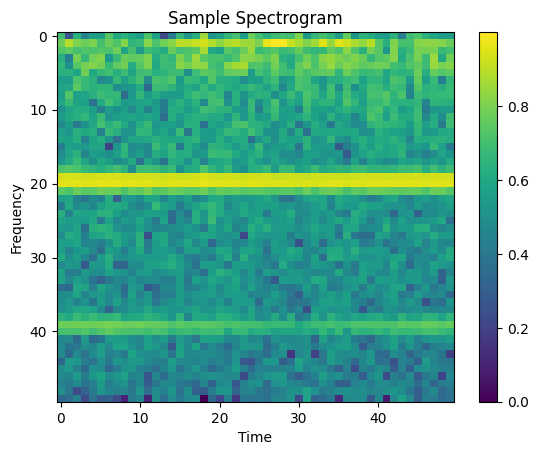

0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [21]:
plt.imshow(create_spectrogram(X[0][0]), aspect='auto', cmap='viridis')
plt.title('Sample Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
print(y[0])
y

Epoch 1/100: 100%|██████████| 180/180 [00:27<00:00,  6.52it/s, loss=1.8765]



Epoch 1 Training - Accuracy: 0.3611, F1: 0.3492, Precision: 0.3629, Recall: 0.3611

Epoch 1 Validation - Accuracy: 0.5306, F1: 0.4983, Precision: 0.5996, Recall: 0.5306


Epoch 2/100: 100%|██████████| 180/180 [00:29<00:00,  6.11it/s, loss=1.4706]



Epoch 2 Training - Accuracy: 0.5788, F1: 0.5715, Precision: 0.5814, Recall: 0.5788

Epoch 2 Validation - Accuracy: 0.7028, F1: 0.6978, Precision: 0.7141, Recall: 0.7028


Epoch 3/100: 100%|██████████| 180/180 [00:30<00:00,  5.83it/s, loss=1.2106]



Epoch 3 Training - Accuracy: 0.7149, F1: 0.7113, Precision: 0.7152, Recall: 0.7149

Epoch 3 Validation - Accuracy: 0.7306, F1: 0.7214, Precision: 0.7734, Recall: 0.7306


Epoch 4/100: 100%|██████████| 180/180 [00:30<00:00,  5.99it/s, loss=0.9966]



Epoch 4 Training - Accuracy: 0.8313, F1: 0.8303, Precision: 0.8316, Recall: 0.8313

Epoch 4 Validation - Accuracy: 0.6458, F1: 0.6450, Precision: 0.7728, Recall: 0.6458


Epoch 5/100: 100%|██████████| 180/180 [00:31<00:00,  5.74it/s, loss=0.8744]



Epoch 5 Training - Accuracy: 0.8694, F1: 0.8689, Precision: 0.8689, Recall: 0.8694

Epoch 5 Validation - Accuracy: 0.8861, F1: 0.8864, Precision: 0.8904, Recall: 0.8861


Epoch 6/100: 100%|██████████| 180/180 [00:33<00:00,  5.42it/s, loss=0.7891]



Epoch 6 Training - Accuracy: 0.9069, F1: 0.9068, Precision: 0.9068, Recall: 0.9069

Epoch 6 Validation - Accuracy: 0.6667, F1: 0.6295, Precision: 0.8039, Recall: 0.6667


Epoch 7/100: 100%|██████████| 180/180 [00:30<00:00,  5.83it/s, loss=0.7481]



Epoch 7 Training - Accuracy: 0.9233, F1: 0.9232, Precision: 0.9233, Recall: 0.9233

Epoch 7 Validation - Accuracy: 0.8236, F1: 0.8134, Precision: 0.8516, Recall: 0.8236


Epoch 8/100: 100%|██████████| 180/180 [00:31<00:00,  5.81it/s, loss=0.7289]



Epoch 8 Training - Accuracy: 0.9278, F1: 0.9278, Precision: 0.9279, Recall: 0.9278

Epoch 8 Validation - Accuracy: 0.7097, F1: 0.6538, Precision: 0.7347, Recall: 0.7097


Epoch 9/100: 100%|██████████| 180/180 [00:31<00:00,  5.66it/s, loss=0.7125]



Epoch 9 Training - Accuracy: 0.9392, F1: 0.9393, Precision: 0.9395, Recall: 0.9392

Epoch 9 Validation - Accuracy: 0.2847, F1: 0.2580, Precision: 0.8336, Recall: 0.2847


Epoch 10/100: 100%|██████████| 180/180 [00:33<00:00,  5.40it/s, loss=0.6976]



Epoch 10 Training - Accuracy: 0.9441, F1: 0.9441, Precision: 0.9442, Recall: 0.9441

Epoch 10 Validation - Accuracy: 0.8833, F1: 0.8763, Precision: 0.8935, Recall: 0.8833


Epoch 11/100: 100%|██████████| 180/180 [00:35<00:00,  5.08it/s, loss=0.6995]



Epoch 11 Training - Accuracy: 0.9358, F1: 0.9357, Precision: 0.9359, Recall: 0.9358


C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 11 Validation - Accuracy: 0.6528, F1: 0.6046, Precision: 0.6207, Recall: 0.6528


Epoch 12/100: 100%|██████████| 180/180 [00:35<00:00,  5.08it/s, loss=0.6940]



Epoch 12 Training - Accuracy: 0.9455, F1: 0.9455, Precision: 0.9456, Recall: 0.9455

Epoch 12 Validation - Accuracy: 0.6972, F1: 0.6685, Precision: 0.8418, Recall: 0.6972


Epoch 13/100: 100%|██████████| 180/180 [00:37<00:00,  4.75it/s, loss=0.6755]



Epoch 13 Training - Accuracy: 0.9542, F1: 0.9542, Precision: 0.9543, Recall: 0.9542

Epoch 13 Validation - Accuracy: 0.7389, F1: 0.7438, Precision: 0.8666, Recall: 0.7389


Epoch 14/100: 100%|██████████| 180/180 [00:38<00:00,  4.71it/s, loss=0.6816]



Epoch 14 Training - Accuracy: 0.9441, F1: 0.9440, Precision: 0.9443, Recall: 0.9441


C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 14 Validation - Accuracy: 0.6194, F1: 0.5442, Precision: 0.5746, Recall: 0.6194


Epoch 15/100: 100%|██████████| 180/180 [00:37<00:00,  4.80it/s, loss=0.6597]



Epoch 15 Training - Accuracy: 0.9549, F1: 0.9549, Precision: 0.9551, Recall: 0.9549

Epoch 15 Validation - Accuracy: 0.7333, F1: 0.7189, Precision: 0.8320, Recall: 0.7333


Epoch 16/100: 100%|██████████| 180/180 [00:38<00:00,  4.71it/s, loss=0.6795]



Epoch 16 Training - Accuracy: 0.9444, F1: 0.9444, Precision: 0.9446, Recall: 0.9444

Epoch 16 Validation - Accuracy: 0.7694, F1: 0.7435, Precision: 0.8123, Recall: 0.7694


Epoch 17/100: 100%|██████████| 180/180 [00:38<00:00,  4.74it/s, loss=0.6653]



Epoch 17 Training - Accuracy: 0.9542, F1: 0.9542, Precision: 0.9545, Recall: 0.9542


C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 17 Validation - Accuracy: 0.6139, F1: 0.5911, Precision: 0.7309, Recall: 0.6139


Epoch 18/100: 100%|██████████| 180/180 [00:39<00:00,  4.54it/s, loss=0.6536]



Epoch 18 Training - Accuracy: 0.9604, F1: 0.9605, Precision: 0.9607, Recall: 0.9604


C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 18 Validation - Accuracy: 0.7139, F1: 0.6966, Precision: 0.7855, Recall: 0.7139


Epoch 19/100: 100%|██████████| 180/180 [00:41<00:00,  4.35it/s, loss=0.6335]



Epoch 19 Training - Accuracy: 0.9649, F1: 0.9649, Precision: 0.9650, Recall: 0.9649

Epoch 19 Validation - Accuracy: 0.7375, F1: 0.7198, Precision: 0.8340, Recall: 0.7375


Epoch 20/100: 100%|██████████| 180/180 [00:43<00:00,  4.18it/s, loss=0.6266]



Epoch 20 Training - Accuracy: 0.9729, F1: 0.9729, Precision: 0.9731, Recall: 0.9729

Epoch 20 Validation - Accuracy: 0.7750, F1: 0.7534, Precision: 0.8502, Recall: 0.7750


Epoch 21/100: 100%|██████████| 180/180 [00:45<00:00,  3.97it/s, loss=0.6259]



Epoch 21 Training - Accuracy: 0.9722, F1: 0.9722, Precision: 0.9723, Recall: 0.9722

Epoch 21 Validation - Accuracy: 0.7597, F1: 0.7315, Precision: 0.8402, Recall: 0.7597


Epoch 22/100: 100%|██████████| 180/180 [00:44<00:00,  4.06it/s, loss=0.6136]



Epoch 22 Training - Accuracy: 0.9778, F1: 0.9778, Precision: 0.9778, Recall: 0.9778

Epoch 22 Validation - Accuracy: 0.8653, F1: 0.8654, Precision: 0.9049, Recall: 0.8653


Epoch 23/100: 100%|██████████| 180/180 [00:45<00:00,  3.96it/s, loss=0.6054]



Epoch 23 Training - Accuracy: 0.9788, F1: 0.9788, Precision: 0.9790, Recall: 0.9788

Epoch 23 Validation - Accuracy: 0.5583, F1: 0.5070, Precision: 0.6656, Recall: 0.5583


Epoch 24/100: 100%|██████████| 180/180 [00:45<00:00,  3.96it/s, loss=0.6012]



Epoch 24 Training - Accuracy: 0.9806, F1: 0.9806, Precision: 0.9806, Recall: 0.9806

Epoch 24 Validation - Accuracy: 0.6014, F1: 0.5857, Precision: 0.8642, Recall: 0.6014


Epoch 25/100: 100%|██████████| 180/180 [00:46<00:00,  3.86it/s, loss=0.5928]



Epoch 25 Training - Accuracy: 0.9823, F1: 0.9823, Precision: 0.9824, Recall: 0.9823


C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 25 Validation - Accuracy: 0.6139, F1: 0.5829, Precision: 0.7065, Recall: 0.6139


Epoch 26/100: 100%|██████████| 180/180 [00:46<00:00,  3.85it/s, loss=0.5874]



Epoch 26 Training - Accuracy: 0.9837, F1: 0.9837, Precision: 0.9838, Recall: 0.9837

Epoch 26 Validation - Accuracy: 0.9250, F1: 0.9256, Precision: 0.9333, Recall: 0.9250


Epoch 27/100: 100%|██████████| 180/180 [00:46<00:00,  3.85it/s, loss=0.5887]



Epoch 27 Training - Accuracy: 0.9840, F1: 0.9840, Precision: 0.9841, Recall: 0.9840

Epoch 27 Validation - Accuracy: 0.8125, F1: 0.7873, Precision: 0.8631, Recall: 0.8125


Epoch 28/100: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s, loss=0.5715]



Epoch 28 Training - Accuracy: 0.9892, F1: 0.9892, Precision: 0.9892, Recall: 0.9892

Epoch 28 Validation - Accuracy: 0.8847, F1: 0.8832, Precision: 0.8982, Recall: 0.8847


Epoch 29/100: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s, loss=0.5795]



Epoch 29 Training - Accuracy: 0.9892, F1: 0.9892, Precision: 0.9893, Recall: 0.9892

Epoch 29 Validation - Accuracy: 0.9125, F1: 0.9133, Precision: 0.9220, Recall: 0.9125


Epoch 30/100: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s, loss=0.5636]



Epoch 30 Training - Accuracy: 0.9924, F1: 0.9924, Precision: 0.9924, Recall: 0.9924

Epoch 30 Validation - Accuracy: 0.8222, F1: 0.8074, Precision: 0.8787, Recall: 0.8222


Epoch 31/100: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s, loss=0.5603]



Epoch 31 Training - Accuracy: 0.9934, F1: 0.9934, Precision: 0.9934, Recall: 0.9934

Epoch 31 Validation - Accuracy: 0.8722, F1: 0.8783, Precision: 0.9102, Recall: 0.8722


Epoch 32/100: 100%|██████████| 180/180 [00:47<00:00,  3.75it/s, loss=0.5621]



Epoch 32 Training - Accuracy: 0.9913, F1: 0.9913, Precision: 0.9913, Recall: 0.9913

Epoch 32 Validation - Accuracy: 0.8028, F1: 0.7818, Precision: 0.8601, Recall: 0.8028


Epoch 33/100: 100%|██████████| 180/180 [00:49<00:00,  3.64it/s, loss=0.5539]



Epoch 33 Training - Accuracy: 0.9965, F1: 0.9965, Precision: 0.9965, Recall: 0.9965

Epoch 33 Validation - Accuracy: 0.7194, F1: 0.6883, Precision: 0.8446, Recall: 0.7194


Epoch 34/100: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s, loss=0.5500]



Epoch 34 Training - Accuracy: 0.9965, F1: 0.9965, Precision: 0.9965, Recall: 0.9965

Epoch 34 Validation - Accuracy: 0.9264, F1: 0.9266, Precision: 0.9319, Recall: 0.9264


Epoch 35/100: 100%|██████████| 180/180 [00:52<00:00,  3.42it/s, loss=0.5509]



Epoch 35 Training - Accuracy: 0.9948, F1: 0.9948, Precision: 0.9948, Recall: 0.9948

Epoch 35 Validation - Accuracy: 0.9333, F1: 0.9335, Precision: 0.9354, Recall: 0.9333


Epoch 36/100: 100%|██████████| 180/180 [00:55<00:00,  3.24it/s, loss=0.5420]



Epoch 36 Training - Accuracy: 0.9983, F1: 0.9983, Precision: 0.9983, Recall: 0.9983

Epoch 36 Validation - Accuracy: 0.9319, F1: 0.9319, Precision: 0.9327, Recall: 0.9319


Epoch 37/100: 100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=0.5387]



Epoch 37 Training - Accuracy: 0.9979, F1: 0.9979, Precision: 0.9979, Recall: 0.9979

Epoch 37 Validation - Accuracy: 0.8569, F1: 0.8341, Precision: 0.8748, Recall: 0.8569


Epoch 38/100: 100%|██████████| 180/180 [00:55<00:00,  3.24it/s, loss=0.5408]



Epoch 38 Training - Accuracy: 0.9976, F1: 0.9976, Precision: 0.9976, Recall: 0.9976

Epoch 38 Validation - Accuracy: 0.9250, F1: 0.9253, Precision: 0.9297, Recall: 0.9250


Epoch 39/100: 100%|██████████| 180/180 [00:56<00:00,  3.17it/s, loss=0.5358]



Epoch 39 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 39 Validation - Accuracy: 0.7472, F1: 0.6888, Precision: 0.7403, Recall: 0.7472


Epoch 40/100: 100%|██████████| 180/180 [00:56<00:00,  3.18it/s, loss=0.5367]



Epoch 40 Training - Accuracy: 0.9986, F1: 0.9986, Precision: 0.9986, Recall: 0.9986

Epoch 40 Validation - Accuracy: 0.9347, F1: 0.9350, Precision: 0.9367, Recall: 0.9347


Epoch 41/100: 100%|██████████| 180/180 [00:57<00:00,  3.12it/s, loss=0.5363]



Epoch 41 Training - Accuracy: 0.9990, F1: 0.9990, Precision: 0.9990, Recall: 0.9990

Epoch 41 Validation - Accuracy: 0.9083, F1: 0.9079, Precision: 0.9150, Recall: 0.9083


Epoch 42/100: 100%|██████████| 180/180 [00:58<00:00,  3.06it/s, loss=0.5365]



Epoch 42 Training - Accuracy: 0.9983, F1: 0.9983, Precision: 0.9983, Recall: 0.9983

Epoch 42 Validation - Accuracy: 0.8375, F1: 0.8431, Precision: 0.9122, Recall: 0.8375


Epoch 43/100: 100%|██████████| 180/180 [00:59<00:00,  3.03it/s, loss=0.5351]



Epoch 43 Training - Accuracy: 0.9986, F1: 0.9986, Precision: 0.9986, Recall: 0.9986

Epoch 43 Validation - Accuracy: 0.9306, F1: 0.9307, Precision: 0.9346, Recall: 0.9306


Epoch 44/100: 100%|██████████| 180/180 [00:59<00:00,  3.01it/s, loss=0.5313]



Epoch 44 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 44 Validation - Accuracy: 0.9083, F1: 0.9092, Precision: 0.9207, Recall: 0.9083


Epoch 45/100: 100%|██████████| 180/180 [01:00<00:00,  2.98it/s, loss=0.5314]



Epoch 45 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 45 Validation - Accuracy: 0.9278, F1: 0.9281, Precision: 0.9312, Recall: 0.9278


Epoch 46/100: 100%|██████████| 180/180 [01:01<00:00,  2.93it/s, loss=0.5329]



Epoch 46 Training - Accuracy: 0.9990, F1: 0.9990, Precision: 0.9990, Recall: 0.9990

Epoch 46 Validation - Accuracy: 0.9181, F1: 0.9191, Precision: 0.9264, Recall: 0.9181


Epoch 47/100: 100%|██████████| 180/180 [01:06<00:00,  2.72it/s, loss=0.5291]



Epoch 47 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 47 Validation - Accuracy: 0.8931, F1: 0.8972, Precision: 0.9161, Recall: 0.8931


Epoch 48/100: 100%|██████████| 180/180 [01:04<00:00,  2.78it/s, loss=0.5290]



Epoch 48 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 48 Validation - Accuracy: 0.9319, F1: 0.9321, Precision: 0.9345, Recall: 0.9319


Epoch 49/100: 100%|██████████| 180/180 [01:07<00:00,  2.65it/s, loss=0.5282]



Epoch 49 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 49 Validation - Accuracy: 0.9042, F1: 0.9059, Precision: 0.9210, Recall: 0.9042


Epoch 50/100: 100%|██████████| 180/180 [01:08<00:00,  2.65it/s, loss=0.5266]



Epoch 50 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 50 Validation - Accuracy: 0.9264, F1: 0.9272, Precision: 0.9321, Recall: 0.9264


Epoch 51/100: 100%|██████████| 180/180 [01:08<00:00,  2.64it/s, loss=0.5265]



Epoch 51 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 51 Validation - Accuracy: 0.9347, F1: 0.9354, Precision: 0.9379, Recall: 0.9347


Epoch 52/100: 100%|██████████| 180/180 [01:06<00:00,  2.69it/s, loss=0.5262]



Epoch 52 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 52 Validation - Accuracy: 0.9333, F1: 0.9343, Precision: 0.9388, Recall: 0.9333


Epoch 53/100: 100%|██████████| 180/180 [01:08<00:00,  2.64it/s, loss=0.5266]



Epoch 53 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 53 Validation - Accuracy: 0.9181, F1: 0.9182, Precision: 0.9254, Recall: 0.9181


Epoch 54/100: 100%|██████████| 180/180 [01:09<00:00,  2.60it/s, loss=0.5260]



Epoch 54 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 54 Validation - Accuracy: 0.9042, F1: 0.9047, Precision: 0.9169, Recall: 0.9042


Epoch 55/100: 100%|██████████| 180/180 [01:09<00:00,  2.57it/s, loss=0.5237]



Epoch 55 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 55 Validation - Accuracy: 0.9292, F1: 0.9300, Precision: 0.9344, Recall: 0.9292


Epoch 56/100: 100%|██████████| 180/180 [01:09<00:00,  2.60it/s, loss=0.5242]



Epoch 56 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 56 Validation - Accuracy: 0.9347, F1: 0.9352, Precision: 0.9387, Recall: 0.9347


Epoch 57/100: 100%|██████████| 180/180 [01:11<00:00,  2.53it/s, loss=0.5241]



Epoch 57 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 57 Validation - Accuracy: 0.8986, F1: 0.8982, Precision: 0.9128, Recall: 0.8986


Epoch 58/100: 100%|██████████| 180/180 [01:11<00:00,  2.51it/s, loss=0.5225]



Epoch 58 Training - Accuracy: 0.9997, F1: 0.9997, Precision: 0.9997, Recall: 0.9997

Epoch 58 Validation - Accuracy: 0.9361, F1: 0.9362, Precision: 0.9368, Recall: 0.9361


Epoch 59/100: 100%|██████████| 180/180 [01:17<00:00,  2.32it/s, loss=0.5202]



Epoch 59 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 59 Validation - Accuracy: 0.9375, F1: 0.9377, Precision: 0.9397, Recall: 0.9375


Epoch 60/100: 100%|██████████| 180/180 [01:16<00:00,  2.35it/s, loss=0.5209]



Epoch 60 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 60 Validation - Accuracy: 0.9264, F1: 0.9263, Precision: 0.9293, Recall: 0.9264


Epoch 61/100: 100%|██████████| 180/180 [01:17<00:00,  2.32it/s, loss=0.5201]



Epoch 61 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 61 Validation - Accuracy: 0.9375, F1: 0.9379, Precision: 0.9405, Recall: 0.9375


Epoch 62/100: 100%|██████████| 180/180 [01:16<00:00,  2.37it/s, loss=0.5191]



Epoch 62 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 62 Validation - Accuracy: 0.9306, F1: 0.9307, Precision: 0.9326, Recall: 0.9306


Epoch 63/100: 100%|██████████| 180/180 [01:15<00:00,  2.38it/s, loss=0.5191]



Epoch 63 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 63 Validation - Accuracy: 0.9306, F1: 0.9312, Precision: 0.9337, Recall: 0.9306


Epoch 64/100: 100%|██████████| 180/180 [01:15<00:00,  2.38it/s, loss=0.5201]



Epoch 64 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 64 Validation - Accuracy: 0.9333, F1: 0.9335, Precision: 0.9351, Recall: 0.9333


Epoch 65/100: 100%|██████████| 180/180 [01:15<00:00,  2.37it/s, loss=0.5189]



Epoch 65 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 65 Validation - Accuracy: 0.9333, F1: 0.9337, Precision: 0.9348, Recall: 0.9333


Epoch 66/100: 100%|██████████| 180/180 [01:16<00:00,  2.36it/s, loss=0.5201]



Epoch 66 Training - Accuracy: 0.9993, F1: 0.9993, Precision: 0.9993, Recall: 0.9993

Epoch 66 Validation - Accuracy: 0.9292, F1: 0.9295, Precision: 0.9321, Recall: 0.9292


Epoch 67/100: 100%|██████████| 180/180 [01:19<00:00,  2.26it/s, loss=0.5180]



Epoch 67 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 67 Validation - Accuracy: 0.9389, F1: 0.9390, Precision: 0.9403, Recall: 0.9389


Epoch 68/100: 100%|██████████| 180/180 [01:20<00:00,  2.24it/s, loss=0.5173]



Epoch 68 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 68 Validation - Accuracy: 0.9333, F1: 0.9335, Precision: 0.9349, Recall: 0.9333


Epoch 69/100: 100%|██████████| 180/180 [01:20<00:00,  2.23it/s, loss=0.5174]



Epoch 69 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 69 Validation - Accuracy: 0.9389, F1: 0.9390, Precision: 0.9410, Recall: 0.9389


Epoch 70/100: 100%|██████████| 180/180 [01:21<00:00,  2.21it/s, loss=0.5173]



Epoch 70 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 70 Validation - Accuracy: 0.9417, F1: 0.9419, Precision: 0.9435, Recall: 0.9417


Epoch 71/100: 100%|██████████| 180/180 [01:22<00:00,  2.18it/s, loss=0.5171]



Epoch 71 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 71 Validation - Accuracy: 0.9431, F1: 0.9431, Precision: 0.9444, Recall: 0.9431


Epoch 72/100: 100%|██████████| 180/180 [01:21<00:00,  2.21it/s, loss=0.5174]



Epoch 72 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 72 Validation - Accuracy: 0.9333, F1: 0.9337, Precision: 0.9378, Recall: 0.9333


Epoch 73/100: 100%|██████████| 180/180 [01:22<00:00,  2.19it/s, loss=0.5165]



Epoch 73 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 73 Validation - Accuracy: 0.9458, F1: 0.9459, Precision: 0.9463, Recall: 0.9458


Epoch 74/100: 100%|██████████| 180/180 [01:25<00:00,  2.10it/s, loss=0.5170]



Epoch 74 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 74 Validation - Accuracy: 0.9486, F1: 0.9487, Precision: 0.9489, Recall: 0.9486


Epoch 75/100: 100%|██████████| 180/180 [01:25<00:00,  2.09it/s, loss=0.5163]



Epoch 75 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 75 Validation - Accuracy: 0.9403, F1: 0.9403, Precision: 0.9405, Recall: 0.9403


Epoch 76/100: 100%|██████████| 180/180 [01:26<00:00,  2.07it/s, loss=0.5159]



Epoch 76 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 76 Validation - Accuracy: 0.9403, F1: 0.9405, Precision: 0.9415, Recall: 0.9403


Epoch 77/100: 100%|██████████| 180/180 [01:29<00:00,  2.00it/s, loss=0.5155]



Epoch 77 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 77 Validation - Accuracy: 0.9431, F1: 0.9431, Precision: 0.9438, Recall: 0.9431


Epoch 78/100: 100%|██████████| 180/180 [01:33<00:00,  1.92it/s, loss=0.5152]



Epoch 78 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 78 Validation - Accuracy: 0.9444, F1: 0.9445, Precision: 0.9450, Recall: 0.9444


Epoch 79/100: 100%|██████████| 180/180 [01:33<00:00,  1.92it/s, loss=0.5158]



Epoch 79 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 79 Validation - Accuracy: 0.9389, F1: 0.9392, Precision: 0.9405, Recall: 0.9389


Epoch 80/100: 100%|██████████| 180/180 [01:33<00:00,  1.93it/s, loss=0.5151]



Epoch 80 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 80 Validation - Accuracy: 0.9458, F1: 0.9458, Precision: 0.9459, Recall: 0.9458


Epoch 81/100: 100%|██████████| 180/180 [01:33<00:00,  1.92it/s, loss=0.5143]



Epoch 81 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 81 Validation - Accuracy: 0.9389, F1: 0.9391, Precision: 0.9403, Recall: 0.9389


Epoch 82/100: 100%|██████████| 180/180 [01:34<00:00,  1.91it/s, loss=0.5152]



Epoch 82 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 82 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9423, Recall: 0.9417


Epoch 83/100: 100%|██████████| 180/180 [01:34<00:00,  1.90it/s, loss=0.5152]



Epoch 83 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 83 Validation - Accuracy: 0.9389, F1: 0.9391, Precision: 0.9400, Recall: 0.9389


Epoch 84/100: 100%|██████████| 180/180 [01:32<00:00,  1.94it/s, loss=0.5148]



Epoch 84 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 84 Validation - Accuracy: 0.9389, F1: 0.9390, Precision: 0.9394, Recall: 0.9389


Epoch 85/100: 100%|██████████| 180/180 [01:33<00:00,  1.92it/s, loss=0.5151]



Epoch 85 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 85 Validation - Accuracy: 0.9431, F1: 0.9431, Precision: 0.9434, Recall: 0.9431


Epoch 86/100: 100%|██████████| 180/180 [01:35<00:00,  1.89it/s, loss=0.5139]



Epoch 86 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 86 Validation - Accuracy: 0.9431, F1: 0.9432, Precision: 0.9437, Recall: 0.9431


Epoch 87/100: 100%|██████████| 180/180 [01:35<00:00,  1.88it/s, loss=0.5147]



Epoch 87 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 87 Validation - Accuracy: 0.9444, F1: 0.9445, Precision: 0.9449, Recall: 0.9444


Epoch 88/100: 100%|██████████| 180/180 [01:38<00:00,  1.83it/s, loss=0.5146]



Epoch 88 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 88 Validation - Accuracy: 0.9431, F1: 0.9431, Precision: 0.9436, Recall: 0.9431


Epoch 89/100: 100%|██████████| 180/180 [01:38<00:00,  1.82it/s, loss=0.5145]



Epoch 89 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 89 Validation - Accuracy: 0.9417, F1: 0.9417, Precision: 0.9421, Recall: 0.9417


Epoch 90/100: 100%|██████████| 180/180 [01:39<00:00,  1.82it/s, loss=0.5141]



Epoch 90 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 90 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9423, Recall: 0.9417


Epoch 91/100: 100%|██████████| 180/180 [01:41<00:00,  1.78it/s, loss=0.5147]



Epoch 91 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 91 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9423, Recall: 0.9417


Epoch 92/100: 100%|██████████| 180/180 [01:39<00:00,  1.80it/s, loss=0.5140]



Epoch 92 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 92 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9423, Recall: 0.9417


Epoch 93/100: 100%|██████████| 180/180 [01:40<00:00,  1.79it/s, loss=0.5140]



Epoch 93 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 93 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9422, Recall: 0.9417


Epoch 94/100: 100%|██████████| 180/180 [01:42<00:00,  1.76it/s, loss=0.5148]



Epoch 94 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 94 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9422, Recall: 0.9417


Epoch 95/100: 100%|██████████| 180/180 [01:41<00:00,  1.77it/s, loss=0.5151]



Epoch 95 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 95 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9424, Recall: 0.9417


Epoch 96/100: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s, loss=0.5153]



Epoch 96 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 96 Validation - Accuracy: 0.9431, F1: 0.9432, Precision: 0.9435, Recall: 0.9431


Epoch 97/100: 100%|██████████| 180/180 [01:43<00:00,  1.74it/s, loss=0.5153]



Epoch 97 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 97 Validation - Accuracy: 0.9431, F1: 0.9432, Precision: 0.9435, Recall: 0.9431


Epoch 98/100: 100%|██████████| 180/180 [01:44<00:00,  1.73it/s, loss=0.5169]



Epoch 98 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 98 Validation - Accuracy: 0.9417, F1: 0.9418, Precision: 0.9424, Recall: 0.9417


Epoch 99/100: 100%|██████████| 180/180 [01:48<00:00,  1.66it/s, loss=0.5182]



Epoch 99 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 99 Validation - Accuracy: 0.9417, F1: 0.9417, Precision: 0.9421, Recall: 0.9417


Epoch 100/100: 100%|██████████| 180/180 [01:52<00:00,  1.60it/s, loss=0.5210]



Epoch 100 Training - Accuracy: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 100 Validation - Accuracy: 0.9375, F1: 0.9377, Precision: 0.9384, Recall: 0.9375


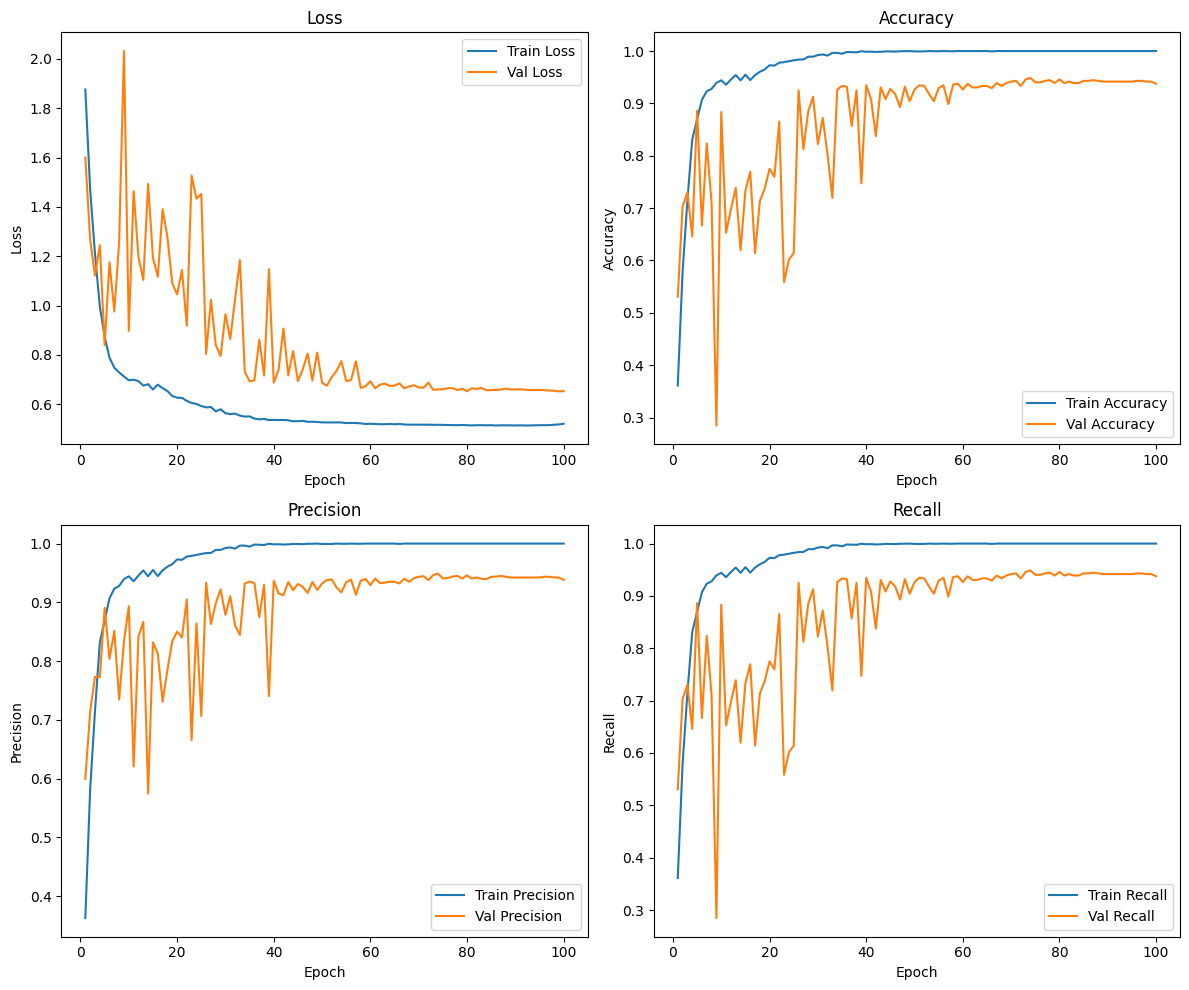

In [22]:
# Update dataset creation
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use smaller batch size for CPU
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# Train with optimized parameters
num_classes=10
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.5
)

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    learning_rate=0.001
)

In [23]:
from torchsummary import summary

model = EEGClassifier()
summary(model, input_size=(1, 50, 50))
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             320
       BatchNorm2d-2           [-1, 32, 50, 50]              64
              ReLU-3           [-1, 32, 50, 50]               0
         MaxPool2d-4           [-1, 32, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          18,496
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 256, 6, 6]         295,168
      BatchNorm2d-14            [-1, 25

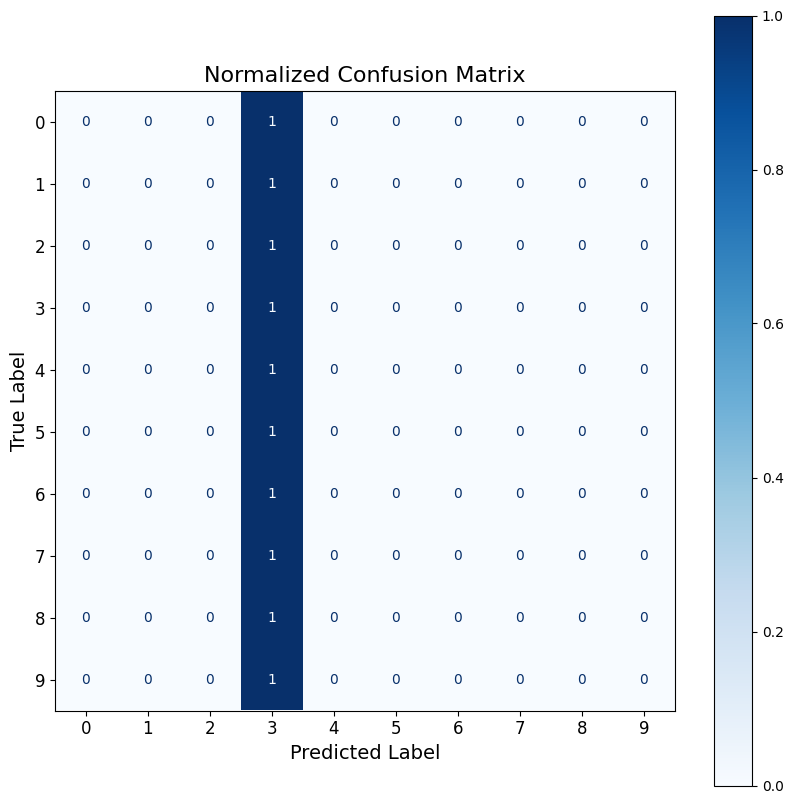

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.float()
        outputs, _ = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

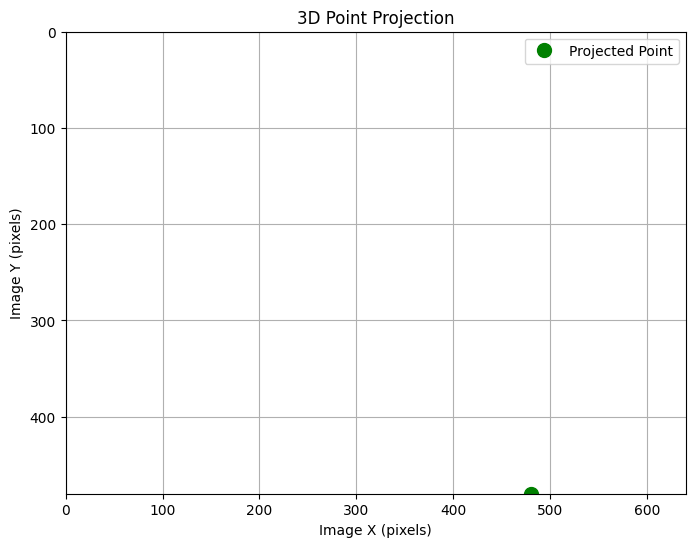

3D World Coordinates: [ 2  3 10]
2D Image Coordinates: (480.0, 480.0)


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 3D world coordinate of a point (X, Y, Z)
world_point = np.array([2, 3, 10])

focal_length = 800  # in pixels
cx, cy = 320, 240   # principal point (center of the image)
K = np.array([
    [focal_length, 0, cx],
    [0, focal_length, cy],
    [0, 0, 1]
])

world_point_homogeneous = np.append(world_point, 1)
projected = K @ world_point_homogeneous[:3]
projected = projected.astype(float)
projected /= projected[2]
u, v = projected[0], projected[1]

plt.figure(figsize=(8, 6))  
plt.plot(u, v, 'go', markersize=10, label='Projected Point')
plt.title('3D Point Projection')
plt.xlabel('Image X (pixels)')
plt.ylabel('Image Y (pixels)')
plt.grid(True)
plt.legend()
plt.axis([0, 640, 480, 0])
plt.show()

print(f"3D World Coordinates: {world_point}")
print(f"2D Image Coordinates: ({u:.1f}, {v:.1f})")

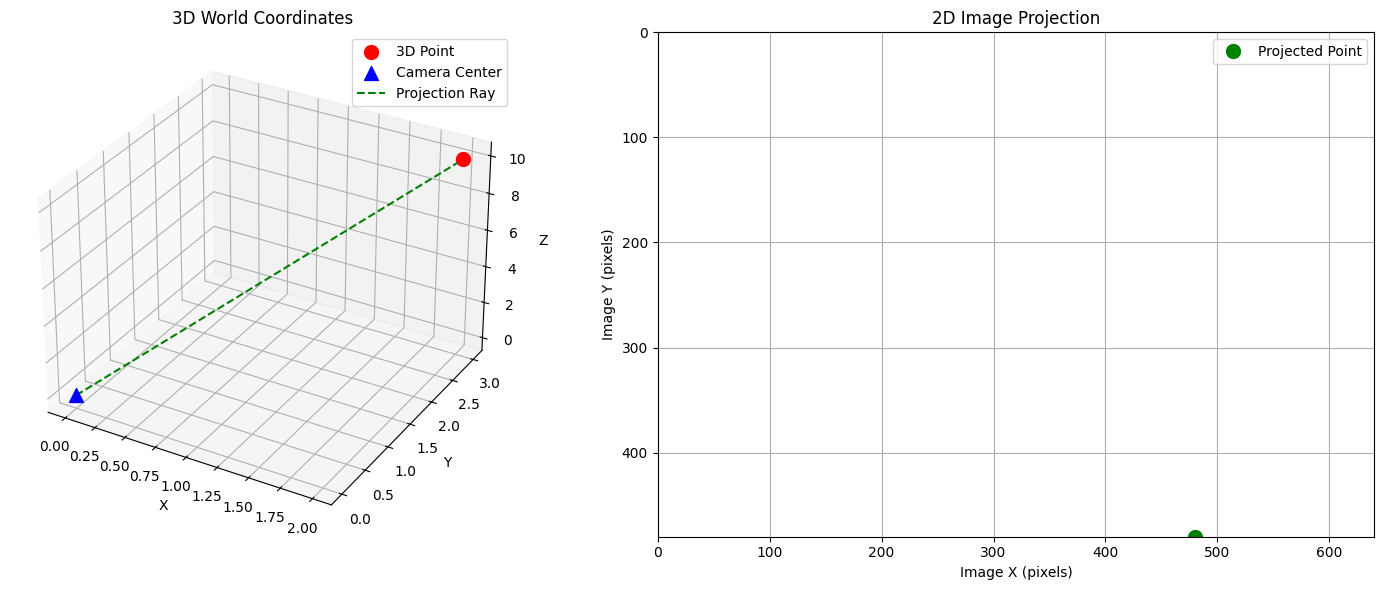

3D World Coordinates: [ 2  3 10]
2D Image Coordinates: (480.0, 480.0)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure with two subplots
fig = plt.figure(figsize=(15, 6))

# 3D point visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(world_point[0], world_point[1], world_point[2], c='r', marker='o', s=100, label='3D Point')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D World Coordinates')

# Add camera center and projection lines
ax1.scatter(0, 0, 0, c='b', marker='^', s=100, label='Camera Center')
ax1.plot([0, world_point[0]], [0, world_point[1]], [0, world_point[2]], 'g--', label='Projection Ray')

ax1.legend()
ax1.grid(True)

# 2D projection visualization
ax2 = fig.add_subplot(122)
ax2.plot(u, v, 'go', markersize=10, label='Projected Point')
ax2.set_title('2D Image Projection')
ax2.set_xlabel('Image X (pixels)')
ax2.set_ylabel('Image Y (pixels)')
ax2.grid(True)
ax2.legend()
ax2.axis([0, 640, 480, 0])  # Flip Y-axis to match image coordinates

plt.tight_layout()
plt.show()

print(f"3D World Coordinates: {world_point}")
print(f"2D Image Coordinates: ({u:.1f}, {v:.1f})")

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pt = np.array([4,6,8])
mt = np.array([[1200,0,500],
               [0,1200,300],
               [0,0,1]])
potin = mt@pt
potin = potin.astype(float)
potin /= potin[2]


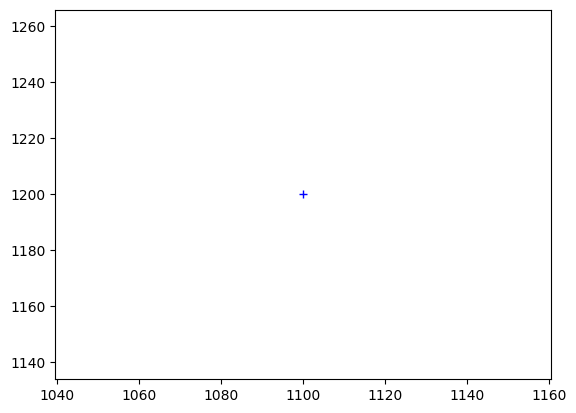

In [17]:
x,y = potin[:2]
plt.plot(x,y,'b+')

In [18]:
x,y

(1100.0, 1200.0)